In [1]:
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt

**Purpose of this notebook**

To optimize placement of magnets such that the cross-sectional area of the volume we are imaging is as homogeneous as possible.

In [2]:
N = 8 #Input number of spaces in NMR Mandhala to optimize
numMagnets = 8 #Input number of magnets to choose from
R = 0.0145 #Input radius of NMR Mandhala to optimize in meters
#R measured from center of Mandhala to center of magnets
V = (0.25**2*1)*(0.025**3) #Volume of each magnet in meters^3

numPoints = 10 #Input number of test points around center to check homogeneity
frac = 0.10 #Input fraction of R to use as radius of circle over which test points will be spread evenly

# Input surface magnetic field values (in Telsa)
#for each of the N magnets to be placed in Mandhala
magnets = np.empty(numMagnets)
magnets[0] = 0.41
magnets[1] = 0.42
magnets[2] = 0.41
magnets[3] = 0.41
magnets[4] = 0.40
magnets[5] = 0.42
magnets[6] = 0.42
magnets[7] = 0.41

**Cell below sets up the particular MANDHALA geometry**

`N` magnets arranged around circumference of circle of radius `R`

`alpha` is the angle from the positive z-axis to the center of each magnet

`beta` is the angle from the positive z-axis of the magnetic dipole orientation of each magnet

`gamma` is the angle from the positive z-axis to each test point

`n0` is a 2D array that gives the normalized position vector of the ith magnet

`P` is a 2D array that gives the position vector of each test point

In [3]:
# DEFINING THE ANGLE ARRAYS
#alpha is an array and alpha[n] gives the angle measured
#from center of first magnet to the center of nth magnet
#going clockwise from positive z-axis (which is in direction of generated magnetic field)
alpha = np.array([n*2*np.pi/N for n in range(N)])

#beta is an array that gives the magnetic field orientation of nth magnet
beta = 2*alpha

#gamma is an array that gives the angle from z axis to the jth test point  
gamma = np.array([j*2*np.pi/numPoints for j in range(numPoints)])

#DEFINING POSITION VECTORS

#this creates a 2D array, n0
#such that n0[i] gives the normalized position vector of the ith magnet in Mandhala
x = np.zeros(N)
y = np.sin(alpha)
z = np.cos(alpha)

n0 = np.vstack([x, y, z]).T

#this creates a 2D array, P
#such that P[j] gives the position vector of the jth test point
x = frac*R*np.zeros(numPoints)
y = frac*R*np.sin(gamma)
z = frac*R*np.cos(gamma)

P = np.vstack([x, y, z]).T

**Cell below defines a function which will evaluate the magnetic field difference at a certain point relative to the magnetic field you would expect if all magnets had the same magnetic moment equal to the average of all the magnetic moments of current arrangement**

>*Inputs:*

>`m` 1D array of the magnetic moments for current arrangement of magnets

>`beta` 1D array with directions of magnetic moments for each magnet

>`rV` 2D array such that `rV[i]` gives the position vector from 'point' to the ith magnet 

>*Output:*

>A vector that gives difference of magnetic field at that point relative to magnetic field if all magnets had the same magnetic moment.

The function to calculate the magnetic field difference is given below:

$$ \Delta \vec{B} = \frac{\mu_0}{4\pi} \sum_{i=0}^{N-1} \frac{3(\Delta \vec{m}_i \cdot \vec{n}_i) \vec{n}_i - \Delta \vec{m}_i}{\| \vec{r}_i \|^3} $$

The cost function we are minimizing becomes the sum over all test point locations of the magnitude of this magnetic field difference.

$$ \textrm{cost function} = \sum_\textrm{test points} \|\Delta \vec{B}\|_\textrm{point}$$

In [4]:
def calcDeltaB(m, beta, rV):
    N = len(m)
    #calculating m0, the average magnetic moment
    m0 = np.mean(m)
    
    #mV gives 2D array that gives magnetic field vector for particular permutation of magnets
    mV = np.array([m[i]*np.array([0, np.sin(beta[i]), np.cos(beta[i])]) for i in range(N)])
    
    #delta gives an array of the difference in magnetic field values of nth magnet with mean 
    delta = m - m0
    #delmV gives a 2D array of the magnetic field difference from mean and direction of the nth magnet as the nth column
    #x,y,z positions (relative to center of circle) as rows 
    delmV = np.array([delta[i]*np.array([0, np.sin(beta[i]), np.cos(beta[i])]) for i in range(N)])
    
    #rnorm finds the norm of rV
    rnorm = np.array([np.linalg.norm(rV[i]) for i in range(N)])
    #nV gives the n-vector to use for this point
    nV = np.array([rV[i]/rnorm[i] for i in range(N)])
    DeltaB = 10**(-7)*np.sum(np.array([(3*(np.dot(delmV[i], nV[i]) * nV[i]) - delmV[i])/(rnorm[i]**3) for i in range(N)]),0)
    return DeltaB

def calcB(m, beta, rV):
    N = len(m)

    #mV gives 2D array that gives magnetic field vector for particular permutation of magnets
    mV = np.array([m[i]*np.array([0, np.sin(beta[i]), np.cos(beta[i])]) for i in range(N)])
    
    #rnorm finds the norm of rV
    rnorm = np.array([np.linalg.norm(rV[i]) for i in range(N)])
    #nV gives the n-vector to use for this point
    nV = np.array([rV[i]/rnorm[i] for i in range(N)])
    B = 10**(-7)*np.sum(np.array([(3*(np.dot(mV[i], nV[i]) * nV[i]) - mV[i])/(rnorm[i]**3) for i in range(N)]),0)
    return B

**Cell below goes through different permutations of magnet arrangements and saves the one with the lowest cost function**

Here we are treating each magnet as a magnetic dipole, and the equation for the magnetic field of a magnetic dipole requires the magnetic moment. The magnetic dipole is given by the following formulat in terms of the magnetization of the magnet $M$ and its volume $V$:
$$ \vec{m} = \vec{M} V$$

The magnetization can be found if we know the residual flux density of the magnet, $B_r$.
$$\vec{M} = \frac{\vec{B}_r}{\mu_0}$$

K&J magnetics gives the maximum residual flux density for the N-52 magnets as 1.48 Teslas and surface field of 0.5461 Teslas for the magnets we use ([Large magnets](https://www.kjmagnetics.com/proddetail.asp?prod=BY088-N52) and [smaller magnets](https://www.kjmagnetics.com/proddetail.asp?prod=BX044-N52)).

Since we measure the surface magnetic fields of each magnet,$B_\textrm{surf}$, I propose using the following:
$$B_r = \frac{B_\textrm{surf}}{0.5461} 1.48 = 2.71 B_\textrm{surf}$$

In [5]:
import time
start = time.time()

#keeps track of current best permutation choice
p_min = np.zeros(N)
#keeps track of current best minimum value of optimization function
val_min = np.Infinity

for p in permutations(range(numMagnets),N):
    
    #m gives an array of the magnetic moments for particular permutation of magnets being tested
    m = 2.71*magnets.take(p)*V/(4*np.pi*10**(-7))
    
    #FINDING COST FUNCTION CONTRIBUTION FROM CENTER OF MANDHALA
    #costV gives a column vector that provides contribution to cost function
    costV = calcDeltaB(m, beta, R*n0)
    
    #val is the norm of the total cost function
    val = np.linalg.norm(costV)
    
    #FINDING COST FUNCTION CONTRIBUTIONS FROM OTHER POINTS IN YZ PLANE NEAR CENTER
    for point in P:
        #this creates a 2D array, rV
        #such that rV[i] gives the position vector from 'point' to the ith magnet
        rV = np.array([(R*n0[i] - point) for i in range(N)])
        costV = calcDeltaB(m, beta, rV)
        val += np.linalg.norm(costV)
    
    if val < val_min:
        val_min = val
        p_min = p

end = time.time()
print("Execution Time:", end - start, " seconds")        
        
print("Minimum Value:", val_min)
print("Permutation corresponding to the minimum value:", p_min)

Execution Time: 83.7636227607727  seconds
Minimum Value: 0.000342591768654
Permutation corresponding to the minimum value: (0, 2, 1, 3, 7, 5, 4, 6)


**Cell below defines a function that will display information for inputted permutation of magnets**

In [6]:
def VisualizePermutation(p):
    print(magnets.take(p))
    m = 2.71*magnets.take(p)*V/(4*np.pi*10**(-7))
    Bcenter = calcB(m, beta, R*n0)
    print("Center Bz value: ", Bcenter[2])
    
    k = 0
    Bxpoint = np.zeros(numPoints)
    Bypoint = np.zeros(numPoints)
    Bzpoint = np.zeros(numPoints)
    for testPoint in P:
        rV = np.array([(R*n0[i] - testPoint) for i in range(N)])
        Bpoint= calcB(m, beta, rV)
        Bxpoint[k] = Bpoint[0]
        Bypoint[k] = Bpoint[1]
        Bzpoint[k] = Bpoint[2]
        k += 1

    deltaBz = max(Bzpoint) - min(Bzpoint)
    print("Range of Bz values over test points: ", deltaBz)

    %matplotlib inline
    plt.plot(gamma, Bzpoint, label = 'Bz')
    plt.plot(gamma, Bypoint, label = 'By')
    plt.plot(gamma, Bxpoint, label = 'Bx')
    plt.legend()
    plt.xlabel("Angle (Radians)")
    plt.ylabel("Magnetic Field Strength (Telsa)")
    plt.title("Magnetic Field Variation Around Center")

**Cells below are visualizing different permutations**

[ 0.41  0.41  0.42  0.41  0.41  0.42  0.4   0.42]
Center Bz value:  0.341948468076
Range of Bz values over test points:  0.00392322885272


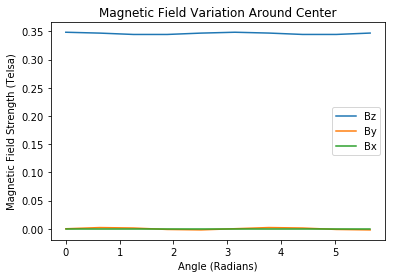

In [7]:
VisualizePermutation(p_min)

[ 0.41  0.42  0.4   0.42  0.41  0.41  0.42  0.41]
Center Bz value:  0.341948468076
Range of Bz values over test points:  0.00392322885272


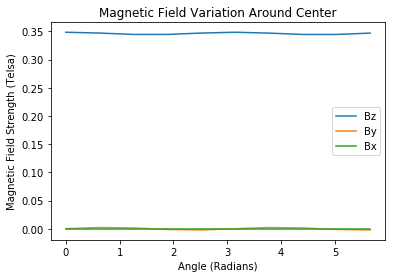

In [11]:
p = [0, 1, 4, 5, 2, 3, 6, 7]
VisualizePermutation(p)

**Possible future steps:**
- This calculation over-estimates the magnetic field, because we are assuming the magnetic field contributed by each magnet is equal to a magnetic dipole with the same magnetic moment as the bar magnet centered at the center of each magnet.

- It would be more accurate to break the bar magnet into cubic pieces of the same magnetization and treat each cube as a magnetic dipole. Since the magnetic moment of the bar magnet scales with the volume, breaking the 1-inch longer magnet into 4 1/4"-cubes would reduce each cubes magnetic dipole moment by 4 and each cube's contribution to the field would be smaller than assumed here due to slightly increased distance from the center plane.

- Could see if making such an adjustment to our model would more accurately predict the magnetic field we measure with the actual magnets (and allow us to more accurately optimize our magnet design).